In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')




In [49]:
df = pd.read_csv("data_gabung.csv")

In [50]:
df

,Unnamed: 0,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,7500,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,5015,TR69555,221,2022-08-01,P4,12000,3,36000,4,23,1,Single,7.50,Potato Chip,12000,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5016,5016,TR21587,425,2022-10-17,P4,12000,1,12000,4,58,1,Married,7.22,Potato Chip,12000,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5017,5017,TR51183,409,2022-07-19,P4,12000,1,12000,4,47,0,Married,28.23,Potato Chip,12000,Gita Ginara,Gita,General Trade,-6.966667,110.416664
5018,5018,TR14963,374,2022-12-16,P4,12000,5,60000,4,32,0,Single,5.40,Potato Chip,12000,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [51]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')



In [52]:
qty = df.groupby(['Date'])['Qty'].sum().reset_index()



In [53]:
train_size = int(len(qty) * 0.8)
train, test = qty[:train_size], qty[train_size:]


In [54]:

def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [55]:

check_stationarity(train['Qty'])



ADF Statistic: -17.309510
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Stationary


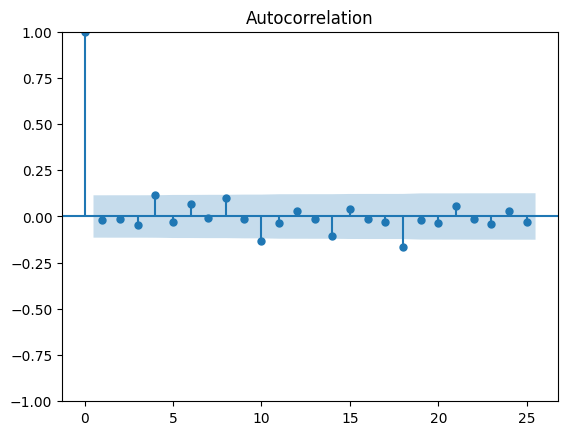

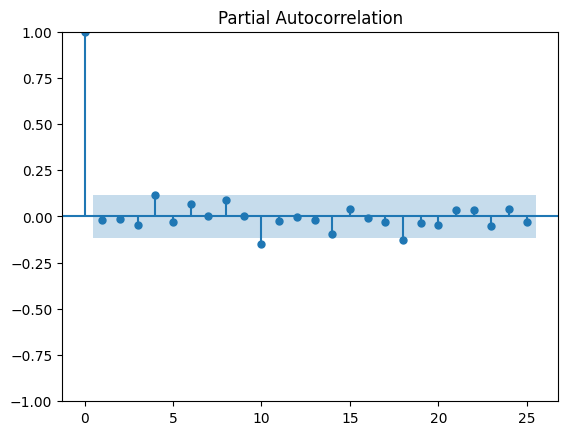

In [56]:
plot_acf(train['Qty'])
plot_pacf(train['Qty'])
plt.show()

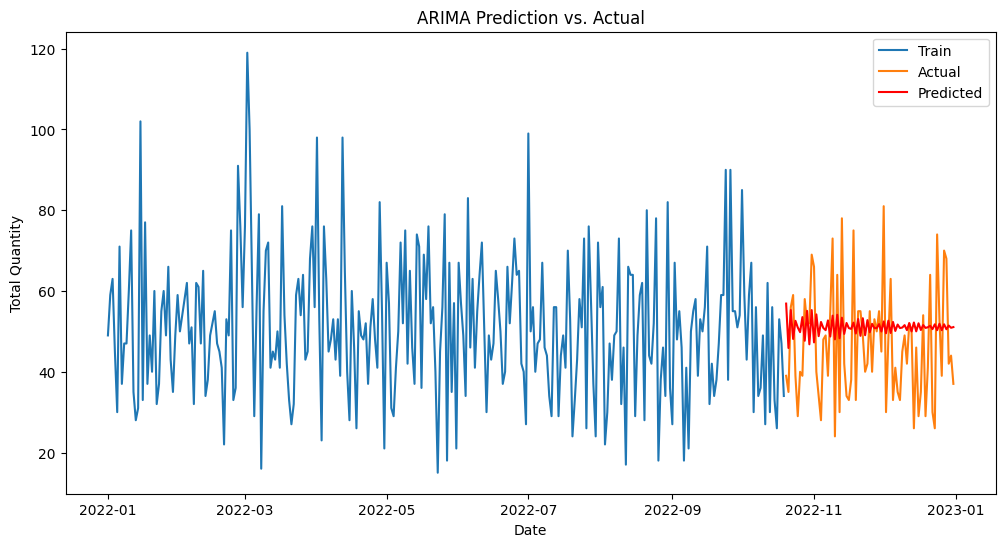

In [57]:

p, d, q = 2, 0, 2


model = ARIMA(train['Qty'], order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Qty'], label='Train')
plt.plot(test['Date'], test['Qty'], label='Actual')
plt.plot(test['Date'], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('ARIMA Prediction vs. Actual')
plt.legend()
plt.show()


In [58]:
# Evaluasi model dengan MAE dan RMSE
mae = mean_absolute_error(test['Qty'], predictions)
rmse = np.sqrt(mean_squared_error(test['Qty'], predictions))

print('MAE: ', mae)
print('RMSE: ', rmse)

MAE:  12.195746057013388
RMSE:  14.37334366477841


In [59]:
from datetime import datetime, timedelta

# Mengambil tanggal terakhir dari data test
last_date = test['Date'].iloc[-1]

# Menambahkan 365 hari untuk mendapatkan 1 tahun ke depan
prediction_dates = [last_date + timedelta(days=i) for i in range(1, 366)]

df_prediction = pd.DataFrame({'Date': prediction_dates})


In [60]:
df_prediction

,Date
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
...,...
360,2023-12-27
361,2023-12-28
362,2023-12-29
363,2023-12-30


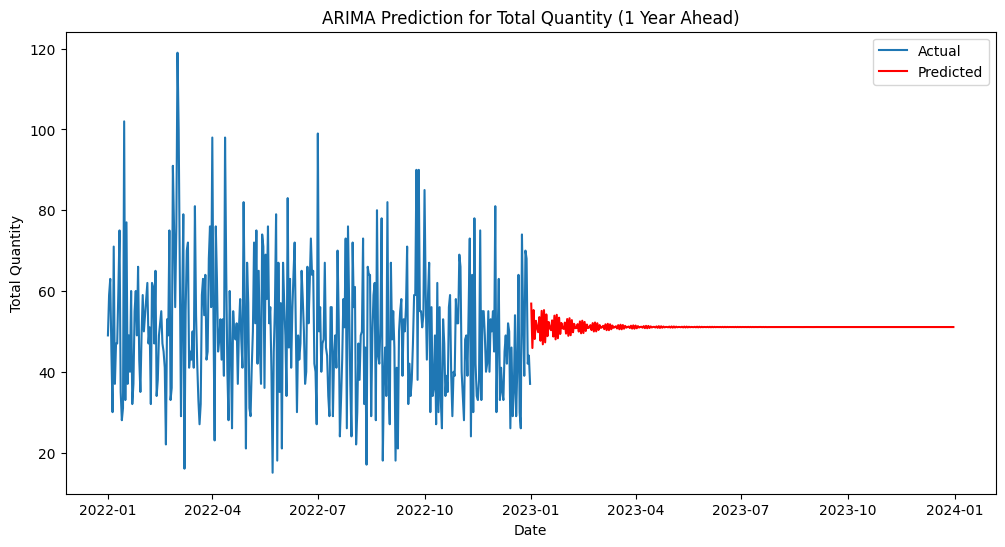

In [61]:
# Menentukan jumlah langkah prediksi (365 hari)
forecast_steps = len(prediction_dates)

# Melakukan prediksi
predictions = model_fit.forecast(steps=forecast_steps)

predictions.reset_index(drop=True, inplace=True)

# Menyimpan hasil prediksi ke dalam DataFrame prediksi
df_prediction['Predicted'] = predictions



# Menampilkan hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(qty['Date'], qty['Qty'], label='Actual')
plt.plot(df_prediction['Date'], df_prediction['Predicted'], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('ARIMA Prediction for Total Quantity (1 Year Ahead)')
plt.legend()
plt.show()



In [62]:
predictions

0      56.880096
1      45.881540
2      55.280315
3      48.116624
4      52.620082
         ...    
360    51.072527
361    51.072450
362    51.072461
363    51.072513
364    51.072406
Name: predicted_mean, Length: 365, dtype: float64

In [63]:
df_prediction

,Date,Predicted
0,2023-01-01,56.880096
1,2023-01-02,45.881540
2,2023-01-03,55.280315
3,2023-01-04,48.116624
4,2023-01-05,52.620082
...,...,...
360,2023-12-27,51.072527
361,2023-12-28,51.072450
362,2023-12-29,51.072461
363,2023-12-30,51.072513


In [64]:
df_prediction['Predicted'].sum()

18644.458992136126

In [66]:
df['Qty'].sum()

18296